### Generate the tuning hyperparameters
In order to fairly evaluate the algorithms, the hyperparameters need to be tuned.
I use random tuning.
This script outputs a text file for hyperparameters.
Each line of the text file can be passed as a command line argument to `run_experiment.py`

In [29]:
# imports
import numpy as np
import pandas as pd
import random
import os
import re
import ast
import pickle
import matplotlib.pyplot as plt

In [30]:
# define hyperparameters and sampling ranges
random.seed(42)

# things to hit
_agent=["DQN","UADQN"]
_action_selection=["softmax", "egreedy"]
_seed = [1]
_n_episodes = [100]

# things to sample from
_lr = [1e-1, 7e-2, 3e-2, 1e-2, 7e-3, 3e-3, 1e-3, 7e-4, 3e-4, 1e-4, 7e-5, 3e-5, 1e-5]
_batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256]
_adam_epsilon = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
_update_target = [4, 8, 16, 32]
_epsilon_final = [0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01]

# generate samples
result = ""
#DQN
for action_selection in _action_selection:
    for n_episodes in _n_episodes:
        for _ in range(200):
            for seed in _seed:
                line = '--agent=DQN '
                line += '--action_selection='+action_selection+ ' '
                line += '--n_episodes='+str(n_episodes) + " "

                line += '--lr='+str(random.sample(_lr,1)[0]) + " "
                line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
                line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
                line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "
                if action_selection=="egreedy":
                    line += '--epsilon_final='+str(random.sample(_epsilon_final,1)[0]) + " "


                result += line + '--seed='+str(seed) + "\n"
# UADQN
for n_episodes in _n_episodes:
    for _ in range(100):
        for seed in _seed:
            line = '--agent=UADQN '
            line += '--n_episodes='+str(50) + " "

            line += '--lr='+str(random.sample(_lr,1)[0]) + " "
            line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
            line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
            line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "


            result += line + '--seed='+str(seed) + "\n"

# write text file

with open("tuning.txt", "w") as f:
    f.write(result)

### Evaluate Tuning Results
After the tuning runs, the results are stored in the `results` folder.
I read them in and generate files `tuned_hyperparameters_DQN_softmax.txt`, `tuned_hyperparameters_DQN_egreedy.txt`, `tuned_hyperparameters_UADQN.txt` with the optimal hyperparameter values for the three algorithms.

In [32]:
tuning_results="results/"
# read results
run_folders = [tuning_results+s for s in os.listdir(tuning_results) if s.startswith("2022")]
run_folders.sort(key=lambda f: int(re.findall(r"[\d]+\Z", f)[0]))

params = []
episode_scores = []
for run_folder in run_folders:
    with open(run_folder+"/experimental-setup", "r") as setup:
        setup_dict = ast.literal_eval(setup.read())
        setup_dict["agent"] = "UADQN" if re.search(r"UADQN", run_folder) else "DQN"
        params.append(setup_dict)
    try:
        with open(run_folder+"/log_data.pkl", "rb") as scores:
            episode_scores.append([score for score, ts in pickle.load(scores)["Episode_score"]])
    except (FileNotFoundError):
        episode_scores.append("")
print(len(run_folders))

500


In [33]:
# generate dataframes:
setups = pd.DataFrame(params)
scores = pd.DataFrame(episode_scores)
#plt.plot(scores, alpha = 0.1, color="blue")
#setups


In [34]:
setups["final_score"] = scores[99]
setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]


#dqn-softmax
dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
dqn_softmax_best_i = setups["final_score"][dqn_softmax_is].idxmax()


#dqn-egreedy
dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index
dqn_egreedy_best_i = setups["final_score"][dqn_egreedy_is].idxmax()


#uadqn
uadqn_is = setups[setups["agent"] == "UADQN"].index
uadqn_best_i = setups["final_score"][uadqn_is].idxmax()



/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_26479/2184603194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_26479/2184603194.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_26479/2184603194.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index


In [35]:

print("Best UADQN:", uadqn_best_i, setups["final_score"][uadqn_best_i])
print("Best Softmax DQN:", setups["final_score"][dqn_softmax_best_i])
print("Best egreedy DQN:", setups["final_score"][dqn_egreedy_best_i])

setups[setups.index == dqn_softmax_best_i]["minibatch_size"]

Best UADQN: 448 -583.7762383299705
Best Softmax DQN: -841.245053326973
Best egreedy DQN: -1076.2432608886447


117    128
Name: minibatch_size, dtype: int64

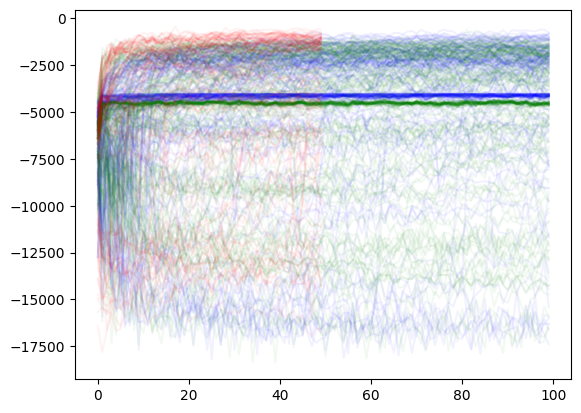

In [41]:
plt.plot(scores.transpose()[dqn_softmax_is], alpha = 0.05, color="blue", label="DQN-softmax")
plt.plot(scores.transpose()[dqn_egreedy_is], alpha = 0.05, color="green", label="DQN-e-greedy")
plt.plot(scores.transpose()[uadqn_is],         alpha=0.05, color="red", label="UA-DQN")


Text(0.5, 0, 'Final Episode Score')

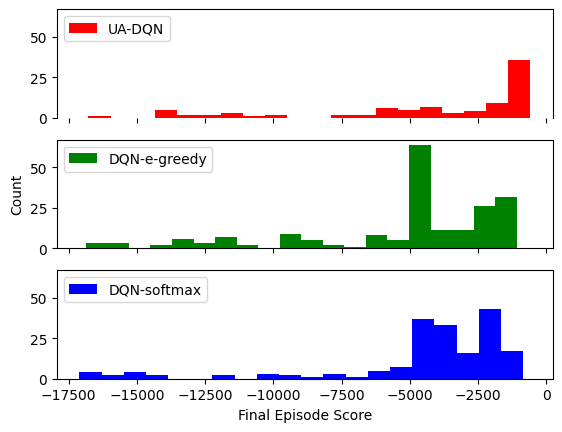

In [101]:
# make histograms of final scores
fig, axs = plt.subplots(3,1, sharex="all", sharey="all")


axs[0].hist(setups["final_score"][uadqn_is], bins=20, color="red", label="UA-DQN")
axs[0].legend(loc="upper left")
axs[1].hist(setups["final_score"][dqn_egreedy_is], bins=20, color="green", label="DQN-e-greedy")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Count")
axs[2].hist(setups["final_score"][dqn_softmax_is], bins=20, color="blue", label="DQN-softmax")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Final Episode Score")

In [61]:
#get hyperparameter correlation
setups[setups["agent"] == "UADQN"][["adam_epsilon", "learning_rate", "minibatch_size", "update_target_frequency","final_score"]].corr()

,adam_epsilon,learning_rate,minibatch_size,update_target_frequency,final_score
adam_epsilon,1.000000,-0.107198,-0.072803,-0.079339,-0.030314
learning_rate,-0.107198,1.000000,-0.034416,0.203342,-0.467654
minibatch_size,-0.072803,-0.034416,1.000000,-0.292960,0.279356
update_target_frequency,-0.079339,0.203342,-0.292960,1.000000,-0.107455
final_score,-0.030314,-0.467654,0.279356,-0.107455,1.000000


In [63]:
#get hyperparameter correlation
setups[setups["action_selection"] == "softmax"][["adam_epsilon", "learning_rate", "minibatch_size", "update_target_frequency","final_score"]].corr()

,adam_epsilon,learning_rate,minibatch_size,update_target_frequency,final_score
adam_epsilon,1.000000,-0.019397,0.004173,-0.040262,-0.015075
learning_rate,-0.019397,1.000000,-0.055345,-0.080941,-0.364610
minibatch_size,0.004173,-0.055345,1.000000,0.086719,-0.181666
update_target_frequency,-0.040262,-0.080941,0.086719,1.000000,0.155881
final_score,-0.015075,-0.364610,-0.181666,0.155881,1.000000


In [77]:
#get hyperparameter correlation
#setups.columns
setups[setups["action_selection"] == "egreedy"][["adam_epsilon", "learning_rate", "minibatch_size", "update_target_frequency","final_score"]].corr()

,adam_epsilon,learning_rate,minibatch_size,update_target_frequency,final_score
adam_epsilon,1.000000,-0.115404,0.023300,0.037089,0.101103
learning_rate,-0.115404,1.000000,0.045904,0.091750,-0.326268
minibatch_size,0.023300,0.045904,1.000000,0.004066,-0.188257
update_target_frequency,0.037089,0.091750,0.004066,1.000000,0.144368
final_score,0.101103,-0.326268,-0.188257,0.144368,1.000000


### Generate Tuning Plots
From the tuning results, some things can be visualized:

For every algorithm:
1. the effect of individual hyperparameters on performance
2. ...
3. ...

In [396]:
setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].groupby(["minibatch_size",]).mean()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("minibatch_size").mean()["final_score"]
#setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby(["update_target_frequency", "minibatch_size"]).describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").mean()["final_score"]

/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/3240964722.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].groupby(["minibatch_size",]).mean()["final_score"]


minibatch_size
1     -4226.298811
2     -3930.229421
4     -3679.592470
8     -5505.641316
16    -5146.633094
32    -6038.256071
64    -6258.051877
128   -5238.466587
256   -7132.336767
Name: final_score, dtype: float64

### Validate Tuning results
For every algorithm, I choose the best performing run and validate its stability by running them with 10 different seeds.
For this, I generate new confic files `tuning_validation.txt` and `tuning_validation.sbatch`



In [390]:
# generate samples
result = ""

#DQN-softmax
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[dqn_softmax_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--action_selection='+run["action_selection"]+ ' '
    line += '--n_episodes=100 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    result += line + '--seed='+str(seed) + "\n"


# DQN-egreedy
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[dqn_egreedy_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--action_selection='+run["action_selection"]+ ' '
    line += '--n_episodes=100 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    if run["action_selection"]=="egreedy":
        line += '--epsilon_final='+str(run["final_exploration_rate"]) + " "
    result += line + '--seed='+str(seed) + "\n"

# UADQN
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[uadqn_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--n_episodes=50 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    result += line + '--seed='+str(seed) + "\n"

# write text file

with open("tuning_validation.txt", "w") as f:
    f.write(result)

In [451]:
# read results of validation runs:
validation_results="validation_results"
# read results
run_folders = [validation_results+s for s in os.listdir(validation_results) if s.startswith("2022")]
run_folders.sort(key=lambda f: int(re.findall(r"[\d]+\Z", f)[0]))

params = []
episode_scores = []
for run_folder in run_folders:
    with open(run_folder+"/experimental-setup", "r") as setup:
        setup_dict = ast.literal_eval(setup.read())
        setup_dict["agent"] = "UADQN" if re.search(r"UADQN", run_folder) else "DQN"
        params.append(setup_dict)
    try:
        with open(run_folder+"/log_data.pkl", "rb") as scores:
            episode_scores.append([score for score, ts in pickle.load(scores)["Episode_score"]])
    except (FileNotFoundError):
        episode_scores.append("")


    # generate dataframes:
setups = pd.DataFrame(params)
scores = pd.DataFrame(episode_scores)

setups["final_score"] = scores[99]
setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]

FileNotFoundError: [Errno 2] No such file or directory: 'validation_results2022-12-12-122439-CityLearn-DQN1/experimental-setup'

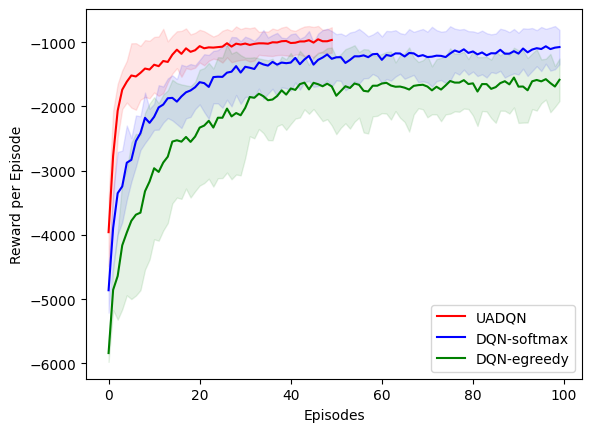

In [461]:
# generate validation plot
uadqn_scores = scores[(setups["agent"] == "UADQN")]
plt.plot(uadqn_scores.mean().transpose(), alpha = 1, color="red", label="UADQN")
plt.fill_between(x=uadqn_scores.transpose().index,
                 y1=uadqn_scores.mean().transpose() - uadqn_scores.std().transpose(),
                 y2=uadqn_scores.mean().transpose() + uadqn_scores.std().transpose(), 
                 alpha = 0.1, color="red")

dqn_softmax_scores = scores[(setups["agent"] == "DQN") & (setups["action_selection"] == "softmax")]
plt.plot(dqn_softmax_scores.mean().transpose(), alpha = 1, color="blue", label="DQN-softmax")
plt.fill_between(x=dqn_softmax_scores.transpose().index,
                 y1=dqn_softmax_scores.mean().transpose() - dqn_softmax_scores.std().transpose(),
                 y2=dqn_softmax_scores.mean().transpose() + dqn_softmax_scores.std().transpose(), 
                 alpha = 0.1, color="blue")

dqn_egreedy_scores = scores[(setups["agent"] == "DQN") & (setups["action_selection"] == "egreedy")]
plt.plot(dqn_egreedy_scores.mean().transpose(), alpha = 1, color="green", label="DQN-egreedy")
plt.fill_between(x=dqn_egreedy_scores.transpose().index,
                 y1=dqn_egreedy_scores.mean().transpose() - dqn_egreedy_scores.std().transpose(),
                 y2=dqn_egreedy_scores.mean().transpose() + dqn_egreedy_scores.std().transpose(), 
                 alpha = 0.1, color="green")
plt.xlabel("Episodes")
plt.ylabel("Reward per Episode")


plt.legend()


plt.savefig("tuning_validation.png")

In [457]:
print(uadqn_scores[49].describe())
print(dqn_softmax_scores[99].describe())
print(dqn_egreedy_scores[99].describe())

count      10.000000
mean     -966.035586
std       198.275433
min     -1302.192636
25%     -1096.308573
50%      -959.296795
75%      -873.672857
max      -583.776238
Name: 49, dtype: float64
count       9.000000
mean    -1076.430612
std       267.513654
min     -1475.019633
25%     -1299.964853
50%     -1033.336059
75%      -866.083961
max      -745.614965
Name: 99, dtype: float64
count      10.000000
mean    -1585.991453
std       330.569148
min     -2174.253933
25%     -1789.730863
50%     -1596.092840
75%     -1292.963302
max     -1121.038102
Name: 99, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-5219.255087,-4652.455182,-3799.152419,-3491.553489,-3154.746725,-2992.192170,-2506.141008,-2790.296780,-2857.283043,-2465.921465,...,-842.554629,-628.984507,-645.955598,-654.968908,-631.242755,-669.289364,-695.801000,-602.756373,-594.043460,-745.614965
1,-4963.825639,-3780.240558,-2484.176634,-2677.997995,-2292.756366,-2777.634618,-2102.916334,-2424.822760,-1969.430375,-1993.381198,...,-1042.464870,-980.450302,-958.738440,-955.271749,-949.976011,-964.970446,-946.183589,-1035.828504,-933.971938,-866.083961
2,-5104.772520,-4172.482647,-4071.629853,-3932.442303,-3206.330504,-2429.070085,-2095.098878,-1970.519488,-1654.291741,-2100.547644,...,-1335.815601,-1385.905630,-1325.306287,-1262.558295,-1254.571246,-1288.358644,-1210.706521,-1188.813423,-1236.480506,-1158.341769
3,-5086.227524,-4380.547398,-4301.475036,-4152.224031,-4002.643485,-3551.130302,-3370.918085,-2616.547180,-2193.654484,-2531.746501,...,-1441.222105,-1389.160458,-1452.067801,-1538.169232,-1324.849099,-1466.586755,-1292.577952,-1452.387003,-1378.087711,-1299.964853
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-5245.881641,-3625.722928,-3337.069667,-3406.275315,-2275.135739,-3010.157176,-2606.647474,-2497.613141,-2485.741904,-2247.471039,...,-1556.680731,-1361.463784,-1580.048163,-1475.768424,-1428.053358,-1436.483543,-1360.849942,-1465.791701,-1363.147386,-1383.443393
6,-4495.012492,-3316.061581,-3084.214733,-2787.604326,-2494.034769,-2660.755541,-2642.711249,-2428.936347,-2125.235251,-2467.287475,...,-1613.638039,-1453.151704,-1683.437385,-1507.478423,-1411.321650,-1581.970051,-1429.650882,-1566.801710,-1586.482593,-1475.019633
7,-4615.888625,-4485.724756,-3172.430044,-3005.431629,-3062.087419,-2859.608548,-2641.526056,-2652.226582,-2550.152783,-2294.482792,...,-701.854197,-676.683599,-742.665030,-801.253206,-789.882381,-750.954699,-710.343500,-761.732240,-656.214637,-773.356721
8,-4762.680305,-3771.466409,-3449.862327,-3228.512415,-3072.880177,-2767.285343,-2724.816960,-2170.804864,-2033.162581,-1907.120277,...,-1128.850869,-1027.116854,-1018.238579,-942.447077,-1062.274668,-1013.849833,-991.774458,-999.189103,-1082.939241,-1033.336059
9,-4251.439223,-2840.117398,-2453.265156,-2527.812240,-2326.381347,-2435.771918,-2169.839940,-2193.762171,-1730.040484,-2293.943494,...,-942.864440,-989.750075,-1020.365021,-899.279593,-994.332319,-790.980808,-942.811885,-899.868150,-940.546837,-952.714153
